In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sys
import os
import minepy
import glob

import matplotlib
import matplotlib.pyplot as plt
import scipy.stats

from PIL import Image
from collections import defaultdict
from decimal import Decimal
from scipy.cluster import hierarchy
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, set_link_color_palette, linkage
from matplotlib.colors import rgb2hex, colorConverter
from sklearn.metrics import v_measure_score, silhouette_score
%matplotlib inline
sns.set_style("white")
os.chdir("/Users/KevinBu/Desktop/clemente_lab/iclust/")

In [2]:
def avg_image(imlist, string):
    w,h=Image.open(imlist[0]).size
    N=len(imlist)

    # Create a numpy array of floats to store the average (assume RGB images)
    arr=np.zeros((h,w,3),np.float)

    # Build up average pixel intensities, casting each image as an array of floats
    for im in imlist:
        imarr=np.array(Image.open(im),dtype=np.float)
        arr=arr+imarr/N

    # Round values in array and cast as 8-bit integer
    arr=np.array(np.round(arr),dtype=np.uint8)

    # Generate, save and preview final image
    out=Image.fromarray(arr,mode="RGB")
    out.save(path + string + '.jpg')

def corr_order(path, R, string):
    try:
        image_list = [path + 'plots/' + x for x in R['ivl']]
    except:
        new_R = [str(x[0]) for x in R['ivl']]
        image_list = [path + 'plots/' + x for x in new_R]
        
    images = map(Image.open, image_list)
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]

    new_im.save(path + string + '.jpg')
    
def score_clusters(max_clust, Z, groups, ids, noncond_dist):
    # groups is the truth, labels is the predicted
    # Z is linkage matrix 
    # ids is the names of the files corresponding to the order in which Z was created
    ss = []
    vms = []
    n_clust = []
    
    for k in range(2, max_clust):
        cut = hierarchy.fcluster(Z, k, criterion='maxclust')
        cluster_dct = dict((ii,[]) for ii in np.unique(cut))
        for iimg,iclus in enumerate(cut):
            cluster_dct[iclus].append(ids[iimg])

        clusters = list(cluster_dct.values())
        observed = dict()
        for i in range(len(clusters)):
            for item in clusters[i]:
                observed[item] = i

        obs_labels = []
        for item in ids:
            obs_labels.append(observed[item])

        if len(np.unique(obs_labels)) > 1:
            ss.append(silhouette_score(noncond_dist, obs_labels, metric='euclidean'))
            vms.append(v_measure_score(groups, obs_labels))
            n_clust.append(len(clusters))
        else:
            ss.append(-1)
            vms.append(-1)
            n_clust.append(1)
    
    corr_score_df = pd.DataFrame({'ss': ss, 'vms': vms, 'n_clust': n_clust})

    best_ss_df = corr_score_df.loc[corr_score_df['ss'] == max(corr_score_df['ss'])]
    best_vms_df = corr_score_df.loc[corr_score_df['vms'] == max(corr_score_df['vms'])]        
    return ss, vms, best_ss_df, best_vms_df, n_clust, corr_score_df

def print_avg_order(Z, k, ids, path, string, R):
    cut = hierarchy.fcluster(Z, 2, criterion='maxclust')
    cluster_dct = dict((ii,[]) for ii in np.unique(cut))
    for iimg,iclus in enumerate(cut):
        cluster_dct[iclus].append(ids[iimg])

    clusters = list(cluster_dct.values())
    '''try:
        image_list = [path + 'plots/' + x for x in R['ivl']]
    except:
        new_R = [str(x[0]) for x in R['ivl']]
        image_list = [path + 'plots/' + x for x in new_R]'''
    i = 0
    for cluster in clusters:
        image_list = [path + 'plots/' + x for x in cluster]
        i += 1
        avg_image(image_list, 'avg_img_' + str(k) + '_' + str(i))

    corr_order(path, R, string)
    
print 'Done'

Done


In [3]:
df_meta = pd.read_csv('../CUTIE/data/lung_pt/Mapping.Pneumotype.Multiomics.RL.NYU.w_metabolites.w_inflamm.txt', 
                     sep = '\t')
df_meta = df_meta.set_index('#SampleID')
df_meta = df_meta.iloc[:,16:99]
df_meta.head()

,glutamic_acid,glycine,alanine,succinic_acid,aspartic_acid,glutamine,serine,methionine,urea,sucrose,...,myristic_acid,1_5_anhydroglucitol,azelaic_acid,behenic_acid,palmitoleic_acid,dihydroabietic_acid,pentadecanoic_acid,threitol,octadecanol,1_monostearin
#SampleID,,,,,,,,,,,,,,,,,,,,,
100716FG.C.1.RL,60088.12140,8.110014e+05,144276.0444,30070.95780,67135.16160,386941.680600,48898.92780,27381.24780,6.677151e+06,6939.451800,...,3.999599e+05,86877.6330,47231.30760,26197.77540,131688.20160,203772.429600,4.797905e+05,5218.037400,36795.232800,42228.447000
100804MB.C.1.RL,120075.13440,1.931722e+06,197367.0879,84091.07970,98779.75800,950017.529700,44450.89110,18537.24030,8.246570e+06,21936.803400,...,7.797187e+05,330270.7623,43232.17980,73379.24880,273568.61550,677860.053600,9.592541e+05,18408.954900,127579.830300,91339.204800
100907LG.C.1.RL,19712.98000,1.569294e+05,51957.7830,213252.20150,38933.13550,693544.878500,28231.80350,22810.73400,1.427332e+07,17108.050500,...,5.918822e+05,648345.8315,126867.10700,57449.25600,281191.57900,548020.844000,8.000654e+05,23373.962000,47874.380000,76528.604500
101007PC.C.1.RL,17490.17800,1.268707e+06,90846.0422,297384.46770,42182.19400,241261.573000,26338.15040,47480.68910,1.038325e+07,10288.340000,...,1.184599e+06,910055.1147,8282.11370,22891.55650,305100.72270,286273.060500,1.412126e+06,13940.700700,26852.567400,47223.480600
101018WG.N.1.RL,73103.15772,1.937921e+05,254635.0241,61839.64963,23902.55961,9848.093782,26992.54855,12718.79319,7.705834e+06,7356.167218,...,2.947451e+05,151010.7498,2930.50564,10047.44791,13755.43464,9050.677283,4.363862e+04,2950.441053,3289.343065,9848.093782


In [4]:
df_otu = pd.read_csv('../CUTIE/data/lung_pt/otu_table_MultiO_merged___L6.txt', skiprows = 1, sep = '\t')
df_otu = df_otu.T
df_otu.columns = df_otu.iloc[0,:]
df_otu = df_otu.drop('#OTU ID')
#df_otu = df_otu.set_index(df_otu.iloc[:,0])
df_otu = df_otu.reindex(df_meta.index)
df_otu.head()

#OTU ID,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__Nitrosopumilus,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__Nitrosotalea,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanothermobacter,k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanocellales;f__Methanocellaceae;g__Methanocella,k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanomicrobiales;f__Methanocorpusculaceae;g__Methanocorpusculum,...,k__Bacteria;p__WPS-2;c__;o__;f__;g__,k__Bacteria;p__WS2;c__SHA-109;o__;f__;g__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__;g__,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__PRR-10;g__,k__Bacteria;p__WS5;c__;o__;f__;g__,k__Bacteria;p__WWE1;c__[Cloacamonae];o__[Cloacamonales];f__[Cloacamonaceae];g__W5,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__CM44,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Trueperaceae;g__Truepera,k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus
#SampleID,,,,,,,,,,,,,,,,,,,,,
100716FG.C.1.RL,0,0,0.000750218,0,0,0.00049568,0,0,0,0,...,0.000308125,0,0,0,0,0,0,0,0,0
100804MB.C.1.RL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100907LG.C.1.RL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101007PC.C.1.RL,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101018WG.N.1.RL,0,0,0,0,0,0.000133311,0,0,0,0,...,0,0,0,0,0,0,0,4.44e-05,0,0


In [5]:
otu_names = df_otu.columns.values
meta_names = df_meta.columns.values
print len(otu_names), len(meta_names)


897 83


In [6]:
df_concat = pd.concat([df_otu, df_meta], axis = 1)
df_concat.head()

,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__Cenarchaeaceae;g__Nitrosopumilus,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__,k__Archaea;p__Crenarchaeota;c__Thaumarchaeota;o__Cenarchaeales;f__SAGMA-X;g__Nitrosotalea,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobrevibacter,k__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanothermobacter,k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanocellales;f__Methanocellaceae;g__Methanocella,k__Archaea;p__Euryarchaeota;c__Methanomicrobia;o__Methanomicrobiales;f__Methanocorpusculaceae;g__Methanocorpusculum,...,myristic_acid,1_5_anhydroglucitol,azelaic_acid,behenic_acid,palmitoleic_acid,dihydroabietic_acid,pentadecanoic_acid,threitol,octadecanol,1_monostearin
#SampleID,,,,,,,,,,,,,,,,,,,,,
100716FG.C.1.RL,0,0,0.000750218,0,0,0.00049568,0,0,0,0,...,3.999599e+05,86877.6330,47231.30760,26197.77540,131688.20160,203772.429600,4.797905e+05,5218.037400,36795.232800,42228.447000
100804MB.C.1.RL,0,0,0,0,0,0,0,0,0,0,...,7.797187e+05,330270.7623,43232.17980,73379.24880,273568.61550,677860.053600,9.592541e+05,18408.954900,127579.830300,91339.204800
100907LG.C.1.RL,0,0,0,0,0,0,0,0,0,0,...,5.918822e+05,648345.8315,126867.10700,57449.25600,281191.57900,548020.844000,8.000654e+05,23373.962000,47874.380000,76528.604500
101007PC.C.1.RL,0,0,0,0,0,0,0,0,0,0,...,1.184599e+06,910055.1147,8282.11370,22891.55650,305100.72270,286273.060500,1.412126e+06,13940.700700,26852.567400,47223.480600
101018WG.N.1.RL,0,0,0,0,0,0.000133311,0,0,0,0,...,2.947451e+05,151010.7498,2930.50564,10047.44791,13755.43464,9050.677283,4.363862e+04,2950.441053,3289.343065,9848.093782


In [7]:
# generating data from WHO
df = pd.read_csv("/Users/KevinBu/Desktop/clemente_lab/CUtIe/data_analysis/" + 
                "cutie_lungpt_kpc1fdr0.05/data_processing/R_matrix_L6_resample_1.txt", sep = "\t")
# df = df.loc[df['var1_index'] > df['var2_index']]

WHO_small_df = df[(df['correlations'] > 0.198) & (df['correlations'] < 0.202)]
WHO_medium_df = df[(df['correlations'] > 0.495) & (df['correlations'] < 0.505)]#.iloc[1:50,] # for spearman
# WHO_medium_df = df[(df['correlations'] > 0.499) & (df['correlations'] < 0.501)] # for pearson
WHO_large_df = df[(df['correlations'] > 0.795) & (df['correlations'] < 0.805)]#.iloc[1:50,]

print len(WHO_small_df)
print len(WHO_medium_df)
print len(WHO_large_df)
df_list = [WHO_small_df, WHO_medium_df, WHO_large_df]
dir_list = ['data/lungpt_kpc_plots/small/plots/', 'data/lungpt_kpc_plots/medium/plots/', 'data/lungpt_kpc_plots/large/plots/']

print 'Done'

81
45
50
Done


In [8]:
# get ids and corrs of plots
# 
path = 'data/lungpt_kpc_plots/medium/'
# files = [os.path.basename(x) for x in glob.glob(path + '/*')]
files = glob.glob(path+'plots/*.jpeg')

pcs = []
ids = []

for f in files:
    ids.append(os.path.basename(f))
    pcs.append(float(os.path.basename(f).split('_')[-1].split('.jpeg')[0]))

print ids


['lungpt_846_13_0.5.jpeg', 'lungpt_675_54_0.5.jpeg', 'lungpt_856_73_0.5.jpeg', 'lungpt_598_29_0.5.jpeg', 'lungpt_651_24_0.5.jpeg', 'lungpt_489_53_0.5.jpeg', 'lungpt_351_41_0.5.jpeg', 'lungpt_494_47_0.5.jpeg', 'lungpt_251_33_0.5.jpeg', 'lungpt_63_34_0.5.jpeg', 'lungpt_243_21_0.5.jpeg', 'lungpt_223_41_0.5.jpeg', 'lungpt_527_34_0.5.jpeg', 'lungpt_598_42_0.5.jpeg', 'lungpt_475_41_0.5.jpeg', 'lungpt_654_22_0.5.jpeg', 'lungpt_95_20_0.5.jpeg', 'lungpt_426_34_0.5.jpeg', 'lungpt_697_54_0.5.jpeg', 'lungpt_634_22_0.5.jpeg', 'lungpt_808_41_0.5.jpeg', 'lungpt_623_34_0.5.jpeg', 'lungpt_870_64_0.5.jpeg', 'lungpt_560_69_0.5.jpeg', 'lungpt_235_39_0.5.jpeg', 'lungpt_489_31_0.5.jpeg', 'lungpt_856_58_0.5.jpeg', 'lungpt_428_76_0.5.jpeg', 'lungpt_530_52_0.5.jpeg', 'lungpt_637_69_0.5.jpeg', 'lungpt_639_39_0.5.jpeg', 'lungpt_34_63_0.5.jpeg', 'lungpt_232_46_0.5.jpeg', 'lungpt_658_6_0.5.jpeg', 'lungpt_872_33_0.5.jpeg', 'lungpt_511_39_0.5.jpeg', 'lungpt_243_5_0.5.jpeg', 'lungpt_366_67_0.5.jpeg', 'lungpt_492_32_0

//anaconda/lib/python2.7/site-packages/matplotlib/axes/_base.py:2809: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
//anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


best ss n_clust: 1 with score -1


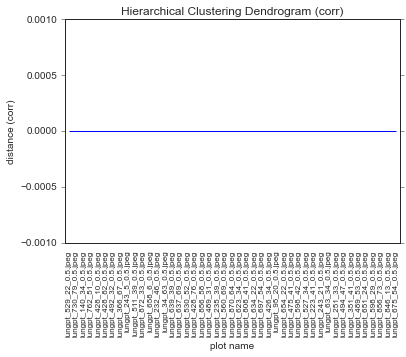

In [9]:
# correlation assessment
# create pd dataframe
corr_df = pd.DataFrame({'pc': pcs, 'id': ids})

# 0 is used as a placeholder to get 2D array as input
X = np.transpose(np.stack((corr_df['pc'], np.zeros(len(corr_df['pc'])))))

# obtain pairwise distances
condensed_dist = distance.pdist(X, metric='euclidean')

# Calculate the distance between each sample, input must be condensed matrix
Z = linkage(condensed_dist, 'ward')

# convert from condensed to 2D for silhouette score
noncond_dist = distance.squareform(condensed_dist)

# Make the dendrogram
fig1, ax1 = plt.subplots()
plt.title('Hierarchical Clustering Dendrogram (corr)')
plt.xlabel('plot name')
plt.ylabel('distance (corr)') # or corr

R = dendrogram(Z, labels = ids, leaf_rotation=90)
max_clust = 20

ss, vms, best_ss_df, best_vms_df, n_clust, corr_score_df = score_clusters(max_clust, Z, 
                                                                          ids, ids,
                                                                         noncond_dist)

print 'best ss n_clust: ' + str(best_ss_df['n_clust'].values[0]) + ' with score ' +  str(best_ss_df['ss'].values[0])
k = best_ss_df['n_clust'].values[0] # toggle for ss too
print_avg_order(Z, k, ids, path, 'corr_order', R)
    

best ss n_clust: 3 with score 0.3106193264591312
[0.2885842249830356, 0.3106193264591312, 0.26150947135864666, 0.2467748101056261, 0.2108947513455942, 0.2214652607122034, 0.19934981178780226, 0.15934936456430165, 0.14477842753912679, 0.14171651451070197, 0.12460316722708191, 0.15544620758805003, 0.13267264131577558, 0.12857330825621469, 0.13708377769222985, 0.14218100089341737, 0.12458975797828652, 0.142170883210553]


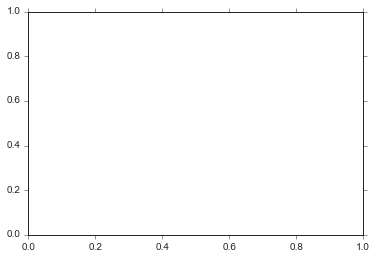

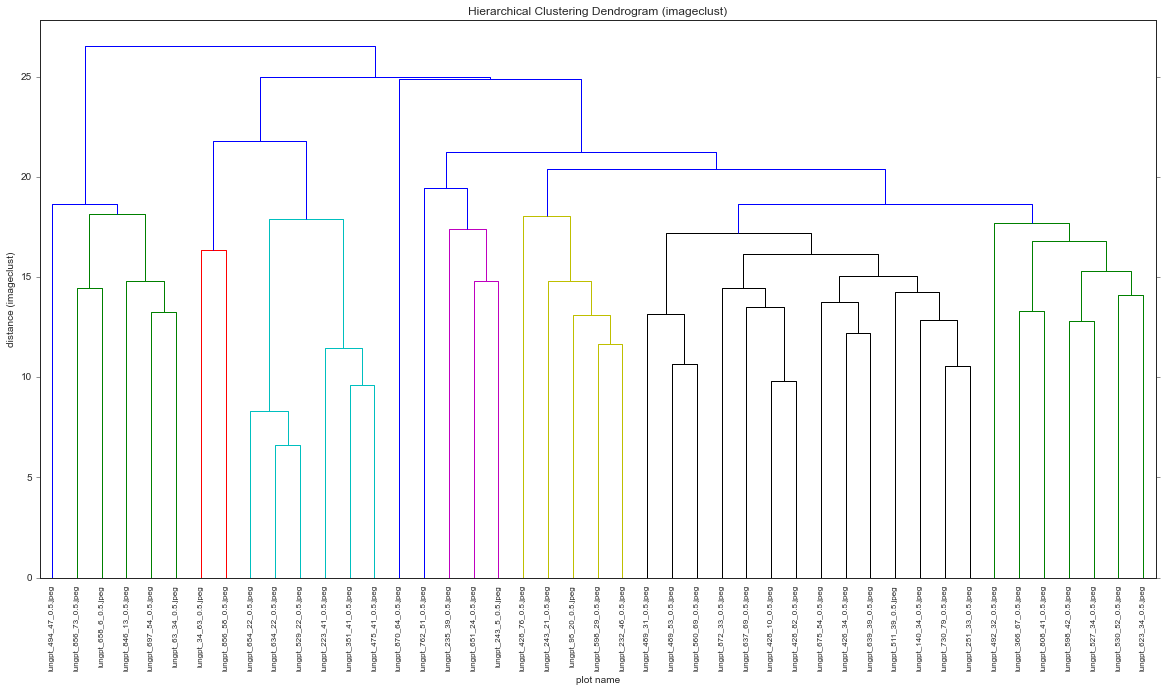

In [10]:
# now you run imagecluster

# source activate yourenv
# export PYTHONPATH=$PYTHONPATH:/Users/KevinBu/tools/sandbox/lib/python3.5/site-packages/
# cd /Users/KevinBu/Desktop/clemente_lab/Software/imagecluster
# Python3 setup.py install  --prefix=/Users/KevinBu/tools/sandbox/
# cd /Users/KevinBu/Desktop/clemente_lab/iclust/data
# python3
# from imagecluster import main
# main.main('lungpt_kpc_plots/small/plots/', 'lungpt_kpc_plots/small/', sim=2)
# sim here doesn't matter, we are only interested in the distance feature matrix

# sim is inappropriately named as it is really k now
# once you know how many clusters you want, you add this to get the clusters
# k = 2
# main.main(data/lungpt_kpc_plots/small/plots/, 'data/lungpt_kpc_plots/small/', sim=k)


path = 'data/lungpt_kpc_plots/medium/'

dfps_df = pd.read_csv(path + 'dfps.txt', sep = '\t', header = None).drop(0) # first row is junk

cond = dfps_df.iloc[:,1:].values.flatten()
sq = distance.squareform(cond)
noncond_dist = distance.squareform(cond)

# get assigned labels
cluster_df = pd.read_csv(path + 'cluster_array.txt', sep = '\t', header = None)
# cluster_df['group'] = [x.split('/')[2].split('_')[0] for x in cluster_df.iloc[:,0].values]
# assigned_labels = cluster_df['group']

# get linkage matrix
df = pd.read_csv(path + 'Z.txt', sep = '\t')
Z = df.values[:,1:]

# get name ordering as processed by software
names = pd.read_csv(path + 'names.txt', sep = '\t')
names = [os.path.basename(str(x[0])) for x in list(names.values[:,1:])]
# true_labels = [x.split('_')[0] for x in names]

fig, ax = plt.subplots()
plt.figure(figsize=(20,10)) 
plt.title('Hierarchical Clustering Dendrogram (imageclust)')
plt.xlabel('plot name')
plt.ylabel('distance (imageclust)') # or corr
R = dendrogram(Z, labels = names, leaf_rotation = 90)
# R['ivl'] = [list(x) for x in R['ivl']]
max_clust = 20

ss, vms, best_ss_df, best_vms_df, n_clust, corr_score_df = score_clusters(max_clust, Z, ids, ids, noncond_dist)
                                                                          #groups[str(sigma)], ids[str(sigma)])
# print 'sigma = ' + str(sigma)
print 'best ss n_clust: ' + str(best_ss_df['n_clust'].values[0]) + ' with score ' +  str(best_ss_df['ss'].values[0])
# print 'best vms n_clust: ' + str(best_vms_df['n_clust'].values[0]) + ' with score ' +  str(best_vms_df['vms'].values[0])
k = best_vms_df['n_clust'].values[0] # toggle here
print_avg_order(Z, k, ids, path, 'imgclust_order', R)
print ss


In [ ]:
xnames_dict = {}
keys = ['k','p','c','o','f','g']
for k in keys:
    xnames_dict[k] = [x.split(k + '__')[1].split(';')[0] for x in xnames]


In [ ]:
# replace xnames
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline


cluster_df.columns = ['name', 'cluster']
for k in keys:
    print 'level: ' + str(k)
    cluster_vars = defaultdict(list)
    for clust in cluster_df['cluster'].unique():
        current_cluster_df = cluster_df[cluster_df['cluster'] == clust]
        for name in current_cluster_df['name']:
            name = os.path.basename(name)
            var1, var2 = int(name.split('_')[1]), int(name.split('_')[2])
            cluster_vars[clust].append(xnames_dict[k][var1])
            cluster_vars[clust].append(xnames_dict[k][var2])

    for clust in cluster_df['cluster'].unique():
        text = cluster_vars[clust]
        wordcloud = WordCloud().generate(' '.join(text))
        # Display the generated image:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()



In [ ]:
np.max(data.values)